In [1]:
__imp

/home/abhishek/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Libraries have been loaded


## Load Additional Libraries

In [2]:
from IPython.display import display
from sklearn.externals import joblib

from sklearn.metrics import roc_auc_score

basepath = os.path.expanduser('../')

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

## Load Data

In [4]:
%%time

app_train   = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/application_train.pkl'))
app_test    = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/application_test.pkl'))

CPU times: user 30.3 ms, sys: 67.4 ms, total: 97.7 ms
Wall time: 469 ms


In [5]:
%%time

# additional tables

bureau       = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/bureau.pkl'))
bureau_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/bureau_balance.pkl'))
# prev_app     = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/previous_application.pkl'))
# installments = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/installments_payments.pkl')) 
# pos_cash     = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/POS_CASH_balance.pkl'))
# credit_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/credit_card_balance.pkl'))

CPU times: user 129 ms, sys: 661 ms, total: 790 ms
Wall time: 6.77 s


## Random Customer

In [6]:
SK_ID_CURR = app_train[app_train.TARGET == 0].sample(n=100).SK_ID_CURR.values[0]; SK_ID_CURR

302830

### Current Application

In [7]:
display_all(app_train.loc[app_train.SK_ID_CURR == SK_ID_CURR].T)

,175031
AMT_ANNUITY,7006.5
AMT_CREDIT,71955
AMT_GOODS_PRICE,67500
AMT_INCOME_TOTAL,54000
AMT_REQ_CREDIT_BUREAU_DAY,0
AMT_REQ_CREDIT_BUREAU_HOUR,0
AMT_REQ_CREDIT_BUREAU_MON,0
AMT_REQ_CREDIT_BUREAU_QRT,0
AMT_REQ_CREDIT_BUREAU_WEEK,0
AMT_REQ_CREDIT_BUREAU_YEAR,2


### Bureau

In [8]:
display_all(bureau.loc[bureau.SK_ID_CURR == SK_ID_CURR].T)

,394704,394705,394706,394707
SK_ID_CURR,302830,302830,302830,302830
SK_ID_BUREAU,6322441,6322442,6322444,6322445
CREDIT_ACTIVE,Closed,Active,Active,Closed
CREDIT_CURRENCY,currency 1,currency 1,currency 1,currency 1
DAYS_CREDIT,-1092,-1092,-2713,-1198
CREDIT_DAY_OVERDUE,0,0,0,0
DAYS_CREDIT_ENDDATE,-483,-404,-2520,-1015
DAYS_ENDDATE_FACT,-571,NaN,NaN,-1012
AMT_CREDIT_MAX_OVERDUE,0,0,NaN,NaN
CNT_CREDIT_PROLONG,0,0,0,0


### Bureau Balance

In [9]:
display_all(bureau.loc[bureau.SK_ID_CURR == SK_ID_CURR, ['SK_ID_BUREAU']]\
                  .merge(bureau_bal, on=['SK_ID_BUREAU'], how='left'))

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,6322441,NaN,NaN
1,6322442,NaN,NaN
2,6322444,NaN,NaN
3,6322445,NaN,NaN


### Previous Application

In [10]:
display_all(prev_app.loc[prev_app.SK_ID_CURR == SK_ID_CURR, :].sort_values(by='DAYS_DECISION', ascending=False).T)

,616787,1004625,1080293,1357844,815845
SK_ID_PREV,1979570,1564640,1383648,2523662,2469663
SK_ID_CURR,302830,302830,302830,302830,302830
NAME_CONTRACT_TYPE,Cash loans,Revolving loans,Cash loans,Consumer loans,Consumer loans
AMT_ANNUITY,NaN,9000,8440.56,2788.74,4784.62
AMT_APPLICATION,0,180000,144000,31270.5,28300.5
AMT_CREDIT,0,180000,163008,14170.5,30168
AMT_DOWN_PAYMENT,NaN,NaN,NaN,17770.5,0
AMT_GOODS_PRICE,NaN,180000,144000,31270.5,28300.5
WEEKDAY_APPR_PROCESS_START,FRIDAY,FRIDAY,FRIDAY,MONDAY,SUNDAY
HOUR_APPR_PROCESS_START,7,8,8,11,10


### POS Cash

In [11]:
display_all(prev_app.loc[prev_app.SK_ID_CURR == SK_ID_CURR, ['SK_ID_CURR', 'SK_ID_PREV']]\
                    .merge(pos_cash.sort_values(by=['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'], 
                                                ascending=[True, True, False]), 
                           on=['SK_ID_CURR', 'SK_ID_PREV'], how='left')) 

,SK_ID_CURR,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,302830,1979570,NaN,NaN,NaN,NaN,NaN,NaN
1,302830,2469663,-72.0,8.0,0.0,Completed,0.0,0.0
2,302830,2469663,-73.0,8.0,0.0,Active,0.0,0.0
3,302830,2469663,-74.0,8.0,1.0,Active,0.0,0.0
4,302830,2469663,-75.0,8.0,2.0,Active,0.0,0.0
5,302830,2469663,-76.0,8.0,4.0,Active,0.0,0.0
6,302830,2469663,-77.0,8.0,5.0,Active,0.0,0.0
7,302830,2469663,-78.0,8.0,6.0,Active,0.0,0.0
8,302830,2469663,-79.0,8.0,7.0,Active,0.0,0.0
9,302830,2469663,-80.0,8.0,8.0,Active,0.0,0.0


### Credit Balance

In [37]:
display_all(prev_app.loc[prev_app.SK_ID_CURR == SK_ID_CURR, ['SK_ID_CURR', 'SK_ID_PREV']]\
                    .merge(credit_bal.sort_values(by=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE'], 
                                                  ascending=[True, True, False]), 
                           on=['SK_ID_CURR', 'SK_ID_PREV'], how='left')) 

,SK_ID_CURR,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,311137,1185379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,311137,1885239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,311137,2706156,-2.0,0.000000,90000.0,0.0,0.0000,0.0,0.0000,0.000000,8.640000,8.640000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,17.0,Active,0.0,0.0
3,311137,2706156,-3.0,0.000000,90000.0,0.0,0.0000,0.0,0.0000,0.000000,8.640000,8.640000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,17.0,Active,0.0,0.0
4,311137,2706156,-4.0,0.000000,90000.0,0.0,0.0000,0.0,0.0000,0.000000,8.640000,8.640000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,17.0,Active,0.0,0.0
5,311137,2706156,-5.0,0.000000,90000.0,0.0,0.0000,0.0,0.0000,0.000000,8.640000,8.640000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,17.0,Active,0.0,0.0
6,311137,2706156,-6.0,0.000000,90000.0,0.0,0.0000,0.0,0.0000,0.000000,8.640000,8.640000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,17.0,Active,0.0,0.0
7,311137,2706156,-7.0,0.000000,90000.0,0.0,0.0000,0.0,0.0000,0.000000,8.640000,8.640000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,17.0,Active,0.0,0.0
8,311137,2706156,-8.0,0.000000,90000.0,0.0,0.0000,0.0,0.0000,0.000000,8.640000,8.640000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,17.0,Active,0.0,0.0
9,311137,2706156,-9.0,0.000000,90000.0,0.0,0.0000,0.0,0.0000,0.000000,8.640000,8.640000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,17.0,Active,0.0,0.0


### Installments

In [36]:
display_all(prev_app.loc[prev_app.SK_ID_CURR == SK_ID_CURR, ['SK_ID_CURR', 'SK_ID_PREV']]\
                    .merge(installments.sort_values(by=['SK_ID_CURR',
                                                        'SK_ID_PREV',
                                                        'NUM_INSTALMENT_NUMBER']), 
                           on=['SK_ID_CURR', 'SK_ID_PREV'], how='left')) 

,SK_ID_CURR,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,311137,1185379,1.0,1,-769.0,-786.0,6675.884766,190.080002
1,311137,1185379,1.0,1,-769.0,-766.0,6675.884766,6485.805176
2,311137,1185379,1.0,2,-739.0,-754.0,6675.884766,281.475006
3,311137,1185379,1.0,2,-739.0,-729.0,6675.884766,6394.410156
4,311137,1185379,1.0,3,-709.0,-729.0,6675.884766,372.869995
5,311137,1185379,1.0,3,-709.0,-698.0,6675.884766,6303.015137
6,311137,1185379,1.0,4,-679.0,-666.0,6675.884766,6211.620117
7,311137,1185379,1.0,4,-679.0,-688.0,6675.884766,464.265015
8,311137,1185379,1.0,5,-649.0,-654.0,6675.884766,6675.884766
9,311137,1185379,1.0,6,-619.0,-622.0,6663.734863,1353.555054


## Hypothesis

### Pensioners vs other Income types

In [6]:
app_train.NAME_INCOME_TYPE.value_counts()

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

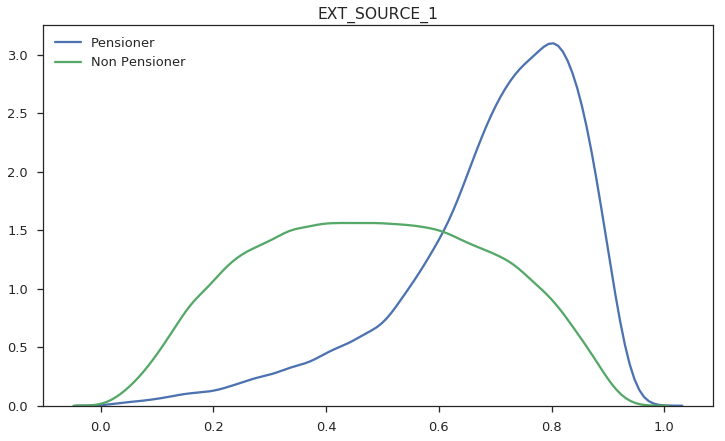

In [12]:
mask = (app_train.NAME_INCOME_TYPE == 'Pensioner')

plt.figure(figsize=(12, 7))
sns.kdeplot(app_train.loc[mask].EXT_SOURCE_1, label='Pensioner')
sns.kdeplot(app_train.loc[~mask].EXT_SOURCE_1, label='Non Pensioner')
plt.title('EXT_SOURCE_1');

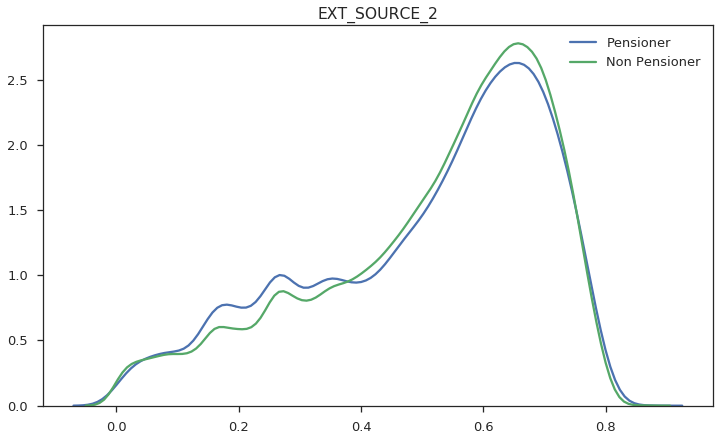

In [13]:
mask = (app_train.NAME_INCOME_TYPE == 'Pensioner')

plt.figure(figsize=(12, 7))
sns.kdeplot(app_train.loc[mask].EXT_SOURCE_2, label='Pensioner')
sns.kdeplot(app_train.loc[~mask].EXT_SOURCE_2, label='Non Pensioner')
plt.title('EXT_SOURCE_2');

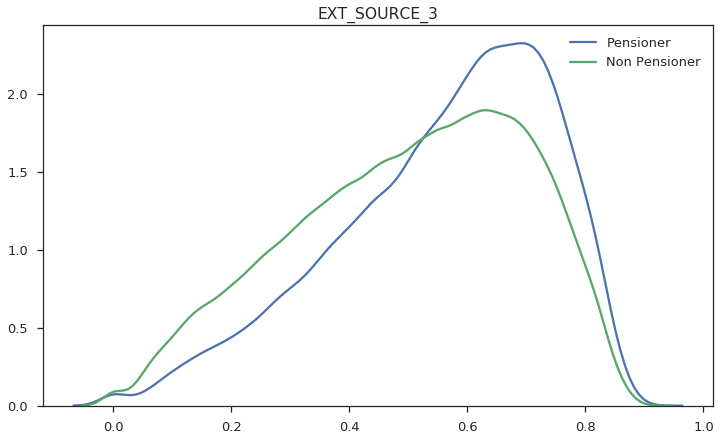

In [14]:
mask = (app_train.NAME_INCOME_TYPE == 'Pensioner')

plt.figure(figsize=(12, 7))
sns.kdeplot(app_train.loc[mask].EXT_SOURCE_3, label='Pensioner')
sns.kdeplot(app_train.loc[~mask].EXT_SOURCE_3, label='Non Pensioner')
plt.title('EXT_SOURCE_3');

** Notes **

- EXT_SOURCE_1 has a completely different distribution for Pensioners and Non-Pensioners.

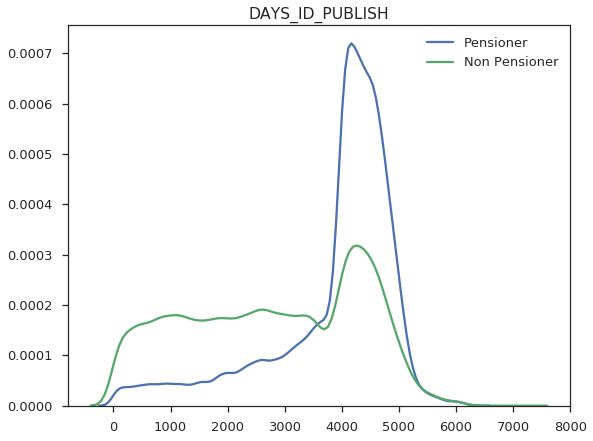

In [18]:
mask = (app_train.NAME_INCOME_TYPE == 'Pensioner')

plt.figure(figsize=(9, 7))
sns.kdeplot(-app_train.loc[mask, 'DAYS_ID_PUBLISH'], label='Pensioner')
sns.kdeplot(-app_train.loc[~mask, 'DAYS_ID_PUBLISH'], label='Non Pensioner')
plt.title('DAYS_ID_PUBLISH');

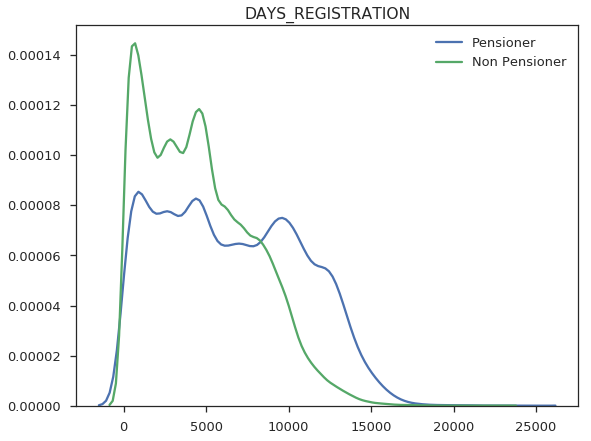

In [19]:
mask = (app_train.NAME_INCOME_TYPE == 'Pensioner')

plt.figure(figsize=(9, 7))
sns.kdeplot(-app_train.loc[mask, 'DAYS_REGISTRATION'], label='Pensioner')
sns.kdeplot(-app_train.loc[~mask, 'DAYS_REGISTRATION'], label='Non Pensioner')
plt.title('DAYS_REGISTRATION');

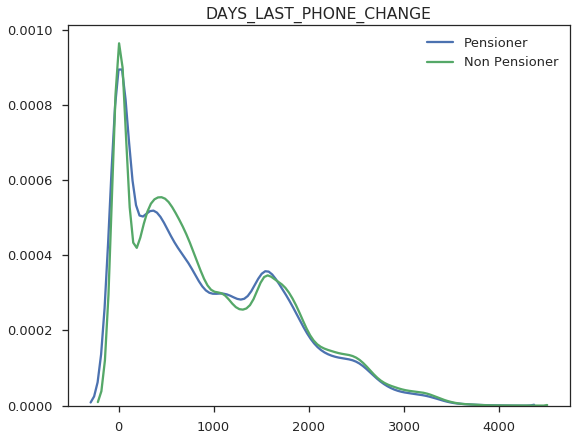

In [21]:
mask = (app_train.NAME_INCOME_TYPE == 'Pensioner')

plt.figure(figsize=(9, 7))
sns.kdeplot(-app_train.loc[mask, 'DAYS_LAST_PHONE_CHANGE'], label='Pensioner')
sns.kdeplot(-app_train.loc[~mask, 'DAYS_LAST_PHONE_CHANGE'], label='Non Pensioner')
plt.title('DAYS_LAST_PHONE_CHANGE');

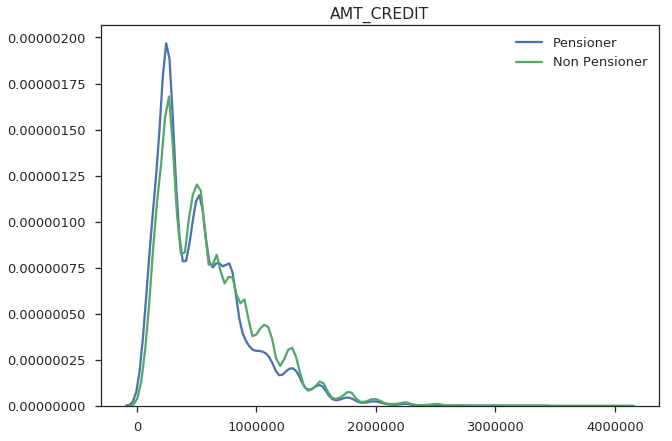

In [24]:
mask = (app_train.NAME_INCOME_TYPE == 'Pensioner')

plt.figure(figsize=(10, 7))
sns.kdeplot(app_train.loc[mask, 'AMT_CREDIT'], label='Pensioner')
sns.kdeplot(app_train.loc[~mask, 'AMT_CREDIT'], label='Non Pensioner')
plt.title('AMT_CREDIT');

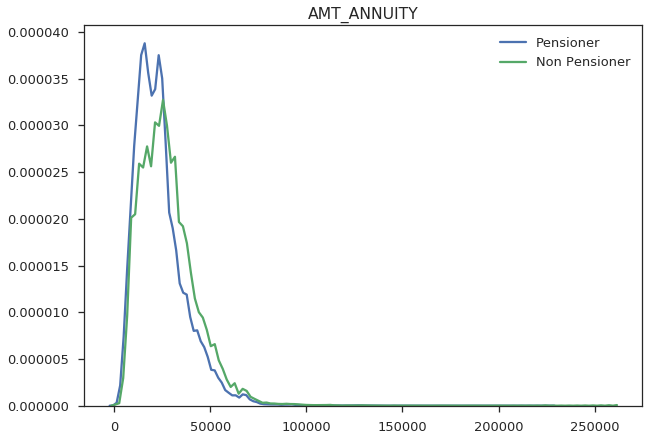

In [25]:
mask = (app_train.NAME_INCOME_TYPE == 'Pensioner')

plt.figure(figsize=(10, 7))
sns.kdeplot(app_train.loc[mask, 'AMT_ANNUITY'], label='Pensioner')
sns.kdeplot(app_train.loc[~mask, 'AMT_ANNUITY'], label='Non Pensioner')
plt.title('AMT_ANNUITY');

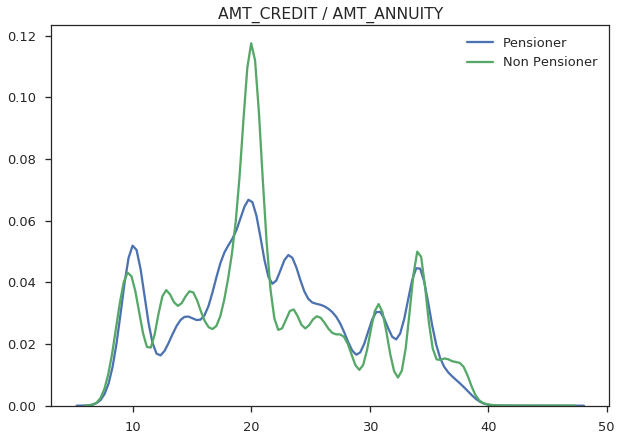

In [26]:
mask = (app_train.NAME_INCOME_TYPE == 'Pensioner')

plt.figure(figsize=(10, 7))
sns.kdeplot(app_train.loc[mask, 'AMT_CREDIT'] / app_train.loc[mask, 'AMT_ANNUITY'], label='Pensioner')
sns.kdeplot(app_train.loc[~mask, 'AMT_CREDIT'] / app_train.loc[~mask, 'AMT_ANNUITY'], label='Non Pensioner')
plt.title('AMT_CREDIT / AMT_ANNUITY');

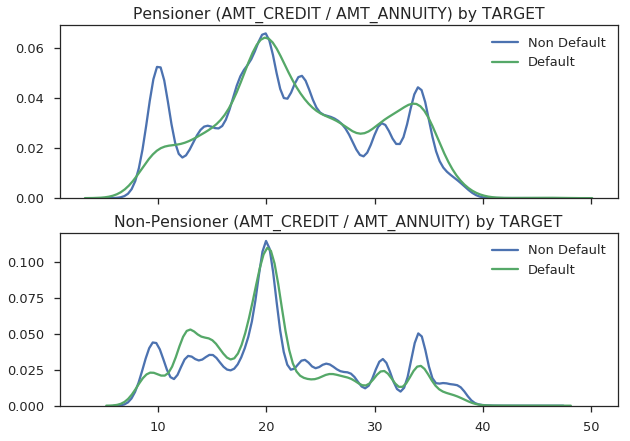

In [71]:
fig, ax = plt.subplots(2, sharex=True, figsize=(10, 7))

mask = (app_train.NAME_INCOME_TYPE == 'Pensioner')

sns.kdeplot(app_train.loc[mask & (app_train.TARGET == 0), 'AMT_CREDIT'] /\
            app_train.loc[mask & (app_train.TARGET == 0), 'AMT_ANNUITY'], label='Non Default', ax=ax[0])

sns.kdeplot(app_train.loc[mask & (app_train.TARGET == 1), 'AMT_CREDIT'] /\
            app_train.loc[mask & (app_train.TARGET == 1), 'AMT_ANNUITY'], label='Default', ax=ax[0])

mask = (app_train.NAME_INCOME_TYPE == 'Pensioner')
sns.kdeplot(app_train.loc[~mask & (app_train.TARGET == 0), 'AMT_CREDIT'] /\
            app_train.loc[~mask & (app_train.TARGET == 0), 'AMT_ANNUITY'], label='Non Default', ax=ax[1])
sns.kdeplot(app_train.loc[~mask & (app_train.TARGET == 1), 'AMT_CREDIT'] /\
            app_train.loc[~mask & (app_train.TARGET == 1), 'AMT_ANNUITY'], label='Default', ax=ax[1])

ax[0].set_title('Pensioner (AMT_CREDIT / AMT_ANNUITY) by TARGET')
ax[1].set_title('Non-Pensioner (AMT_CREDIT / AMT_ANNUITY) by TARGET');

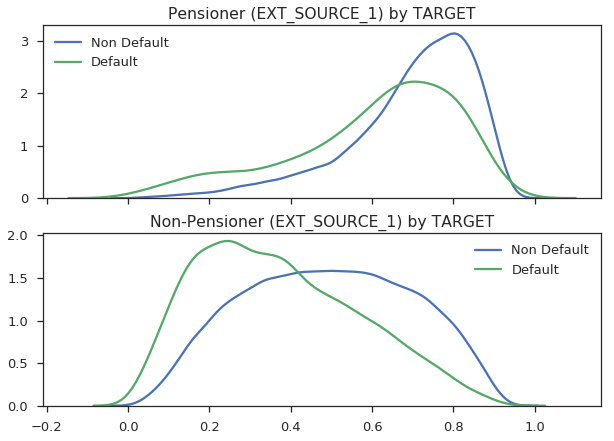

In [72]:
fig, ax = plt.subplots(2, sharex=True, figsize=(10, 7))

mask = (app_train.NAME_INCOME_TYPE == 'Pensioner')

sns.kdeplot(app_train.loc[mask & (app_train.TARGET == 0), 'EXT_SOURCE_1'] , label='Non Default', ax=ax[0])
sns.kdeplot(app_train.loc[mask & (app_train.TARGET == 1), 'EXT_SOURCE_1'], label='Default', ax=ax[0])

mask = (app_train.NAME_INCOME_TYPE == 'Pensioner')
sns.kdeplot(app_train.loc[~mask & (app_train.TARGET == 0), 'EXT_SOURCE_1'], label='Non Default', ax=ax[1])
sns.kdeplot(app_train.loc[~mask & (app_train.TARGET == 1), 'EXT_SOURCE_1'], label='Default', ax=ax[1])

ax[0].set_title('Pensioner (EXT_SOURCE_1) by TARGET')
ax[1].set_title('Non-Pensioner (EXT_SOURCE_1) by TARGET');

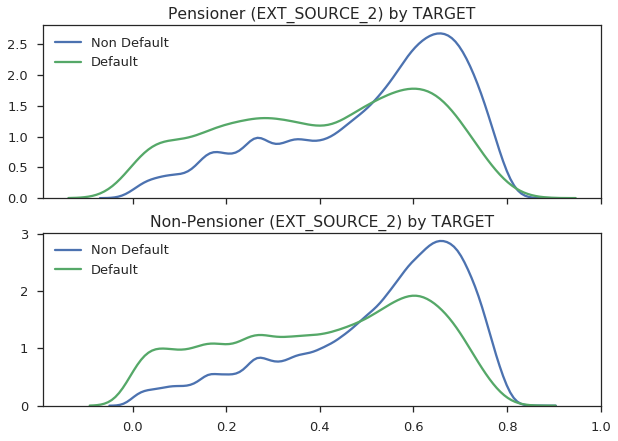

In [73]:
fig, ax = plt.subplots(2, sharex=True, figsize=(10, 7))

mask = (app_train.NAME_INCOME_TYPE == 'Pensioner')

sns.kdeplot(app_train.loc[mask & (app_train.TARGET == 0), 'EXT_SOURCE_2'] , label='Non Default', ax=ax[0])
sns.kdeplot(app_train.loc[mask & (app_train.TARGET == 1), 'EXT_SOURCE_2'], label='Default', ax=ax[0])

mask = (app_train.NAME_INCOME_TYPE == 'Pensioner')
sns.kdeplot(app_train.loc[~mask & (app_train.TARGET == 0), 'EXT_SOURCE_2'], label='Non Default', ax=ax[1])
sns.kdeplot(app_train.loc[~mask & (app_train.TARGET == 1), 'EXT_SOURCE_2'], label='Default', ax=ax[1])

ax[0].set_title('Pensioner (EXT_SOURCE_2) by TARGET')
ax[1].set_title('Non-Pensioner (EXT_SOURCE_2) by TARGET');

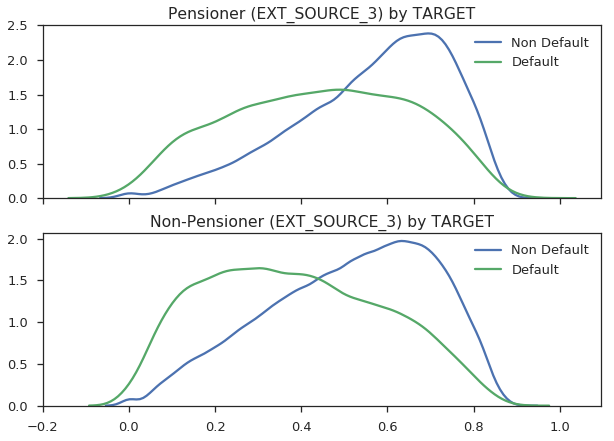

In [74]:
fig, ax = plt.subplots(2, sharex=True, figsize=(10, 7))

mask = (app_train.NAME_INCOME_TYPE == 'Pensioner')

sns.kdeplot(app_train.loc[mask & (app_train.TARGET == 0), 'EXT_SOURCE_3'] , label='Non Default', ax=ax[0])
sns.kdeplot(app_train.loc[mask & (app_train.TARGET == 1), 'EXT_SOURCE_3'], label='Default', ax=ax[0])

mask = (app_train.NAME_INCOME_TYPE == 'Pensioner')
sns.kdeplot(app_train.loc[~mask & (app_train.TARGET == 0), 'EXT_SOURCE_3'], label='Non Default', ax=ax[1])
sns.kdeplot(app_train.loc[~mask & (app_train.TARGET == 1), 'EXT_SOURCE_3'], label='Default', ax=ax[1])

ax[0].set_title('Pensioner (EXT_SOURCE_3) by TARGET')
ax[1].set_title('Non-Pensioner (EXT_SOURCE_3) by TARGET');

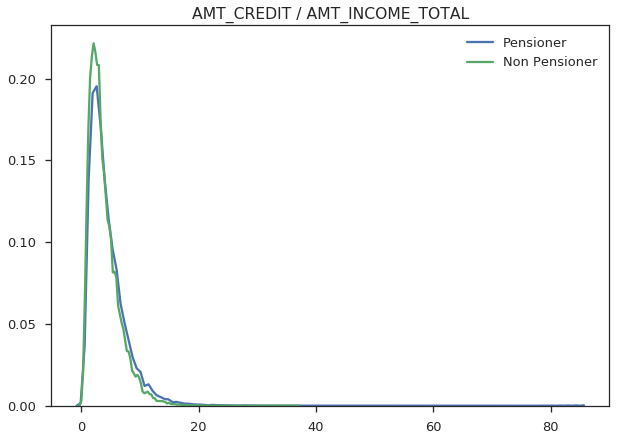

In [29]:
mask = (app_train.NAME_INCOME_TYPE == 'Pensioner')

plt.figure(figsize=(10, 7))
sns.kdeplot(app_train.loc[mask, 'AMT_CREDIT'] / app_train.loc[mask, 'AMT_INCOME_TOTAL'], label='Pensioner')
sns.kdeplot(app_train.loc[~mask, 'AMT_CREDIT'] / app_train.loc[~mask, 'AMT_INCOME_TOTAL'], label='Non Pensioner')
plt.title('AMT_CREDIT / AMT_INCOME_TOTAL');

In [35]:
prev_app.head().T

,0,1,2,3,4
SK_ID_PREV,2030495,2802425,2523466,2819243,1784265
SK_ID_CURR,271877,108129,122040,176158,202054
NAME_CONTRACT_TYPE,Consumer loans,Cash loans,Cash loans,Cash loans,Cash loans
AMT_ANNUITY,1730.43,25188.6,15060.7,47041.3,31924.4
AMT_APPLICATION,17145,607500,112500,450000,337500
AMT_CREDIT,17145,679671,136444,470790,404055
AMT_DOWN_PAYMENT,0,NaN,NaN,NaN,NaN
AMT_GOODS_PRICE,17145,607500,112500,450000,337500
WEEKDAY_APPR_PROCESS_START,SATURDAY,THURSDAY,TUESDAY,MONDAY,THURSDAY
HOUR_APPR_PROCESS_START,15,11,11,7,9


In [32]:
mask = prev_app.NAME_CONTRACT_STATUS == 'Approved'

tmp  = app_train.loc[:, ['SK_ID_CURR', 'NAME_INCOME_TYPE', 'TARGET']]\
                .merge(prev_app.loc[mask, ['SK_ID_CURR', 'CNT_PAYMENT']])

,SK_ID_CURR,NAME_INCOME_TYPE,TARGET,CNT_PAYMENT
0,100002,Working,1.0,24.0
1,100003,State servant,0.0,12.0
2,100003,State servant,0.0,6.0
3,100003,State servant,0.0,12.0
4,100004,Working,0.0,4.0


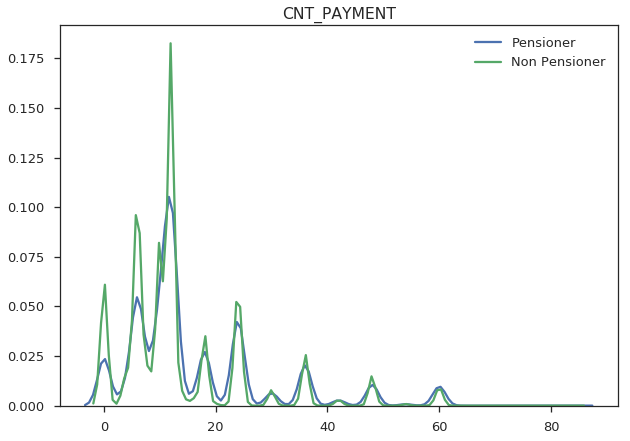

In [33]:
mask = (tmp.NAME_INCOME_TYPE == 'Pensioner')

plt.figure(figsize=(10, 7))
sns.kdeplot(tmp.loc[mask, 'CNT_PAYMENT'], label='Pensioner')
sns.kdeplot(tmp.loc[~mask, 'CNT_PAYMENT'], label='Non Pensioner')
plt.title('CNT_PAYMENT');

In [36]:
mask = prev_app.NAME_CONTRACT_STATUS == 'Approved'

tmp  = app_train.loc[:, ['SK_ID_CURR', 'NAME_INCOME_TYPE', 'TARGET']]\
                .merge(prev_app.loc[mask, ['SK_ID_CURR', 'DAYS_DECISION']])

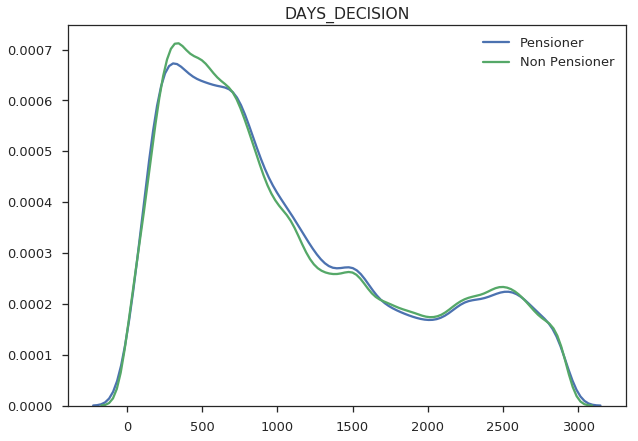

In [37]:
mask = (tmp.NAME_INCOME_TYPE == 'Pensioner')

plt.figure(figsize=(10, 7))
sns.kdeplot(-tmp.loc[mask, 'DAYS_DECISION'], label='Pensioner')
sns.kdeplot(-tmp.loc[~mask, 'DAYS_DECISION'], label='Non Pensioner')
plt.title('DAYS_DECISION');

In [61]:
mask = prev_app.NAME_CONTRACT_STATUS == 'Approved'                                           

tmp  = app_train.loc[:, ['SK_ID_CURR', 'NAME_INCOME_TYPE', 'TARGET']]\
                .merge((installments.AMT_INSTALMENT - installments.AMT_PAYMENT)\
                        .groupby(installments.SK_ID_CURR)\
                        .mean()\
                        .reset_index()\
                        .rename(columns={0: 'diff_inst_payment'}),
                       on='SK_ID_CURR',
                       how='left'
                      )

tmp.head()

,SK_ID_CURR,NAME_INCOME_TYPE,TARGET,diff_inst_payment
0,100002,Working,1.0,0.000000
1,100003,State servant,0.0,0.000000
2,100004,Working,0.0,0.000000
3,100006,Working,0.0,0.000000
4,100007,Working,0.0,452.384308


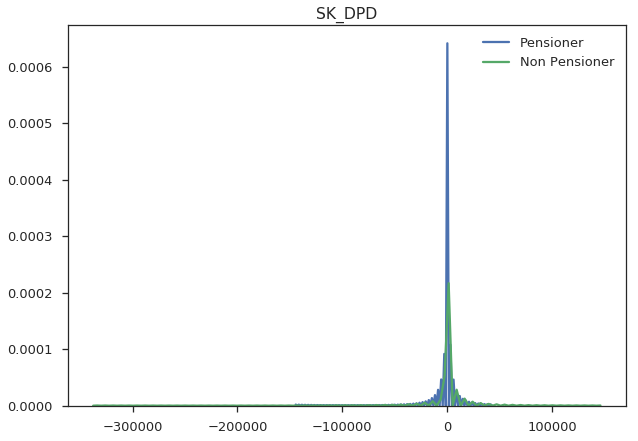

In [63]:
mask = (tmp.NAME_INCOME_TYPE == 'Pensioner')

plt.figure(figsize=(10, 7))

sns.kdeplot(tmp.loc[mask, 'diff_inst_payment'], label='Pensioner')
sns.kdeplot(tmp.loc[~mask, 'diff_inst_payment'], label='Non Pensioner')

plt.title('SK_DPD');

### Number of DPD by Income Type across months.

In [25]:
app_train.NAME_INCOME_TYPE.value_counts()

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

In [26]:
app_train.NAME_INCOME_TYPE.cat.codes.value_counts()

7    158774
1     71617
3     55362
4     21703
6        22
5        18
0        10
2         5
dtype: int64

In [32]:
%%time

tmp = pos_cash[pos_cash.SK_DPD < 100].groupby(['SK_ID_CURR', 'MONTHS_BALANCE'], as_index=False)['SK_DPD'].sum()
tmp = app_train.loc[:, ['SK_ID_CURR', 'NAME_INCOME_TYPE', 'TARGET']]\
               .merge(tmp, on='SK_ID_CURR', how='inner')
tmp.loc[:, 'NAME_INCOME_TYPE'] = tmp.NAME_INCOME_TYPE.cat.codes.astype(np.int)

tmp.head()

,SK_ID_CURR,NAME_INCOME_TYPE,TARGET,MONTHS_BALANCE,SK_DPD
0,100002,Working,1.0,-19,0
1,100002,Working,1.0,-18,0
2,100002,Working,1.0,-17,0
3,100002,Working,1.0,-16,0
4,100002,Working,1.0,-15,0


In [73]:
x = tmp.sample(n=50000)

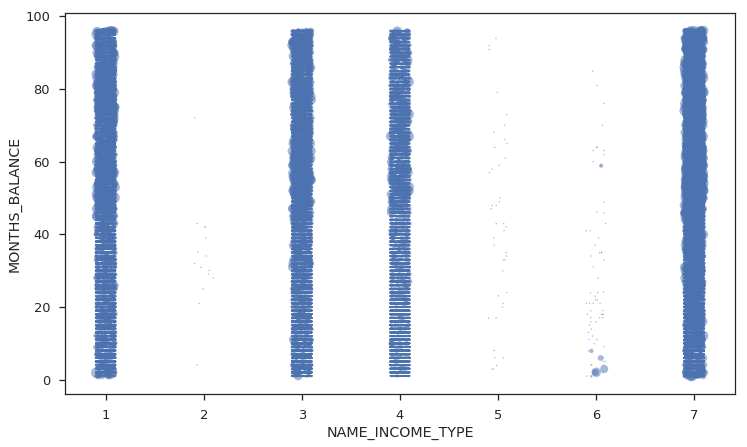

In [66]:
plt.figure(figsize=(12, 7))

sns.regplot(x='NAME_INCOME_TYPE',
            y='MONTHS_BALANCE',
            data=x,
            fit_reg=False,  # do not fit a regression line
            x_jitter=0.1,   # could also dynamically set this with range of data
            y_jitter=0.1,
            scatter_kws={'alpha': 0.5, 's': x.SK_DPD + 2});

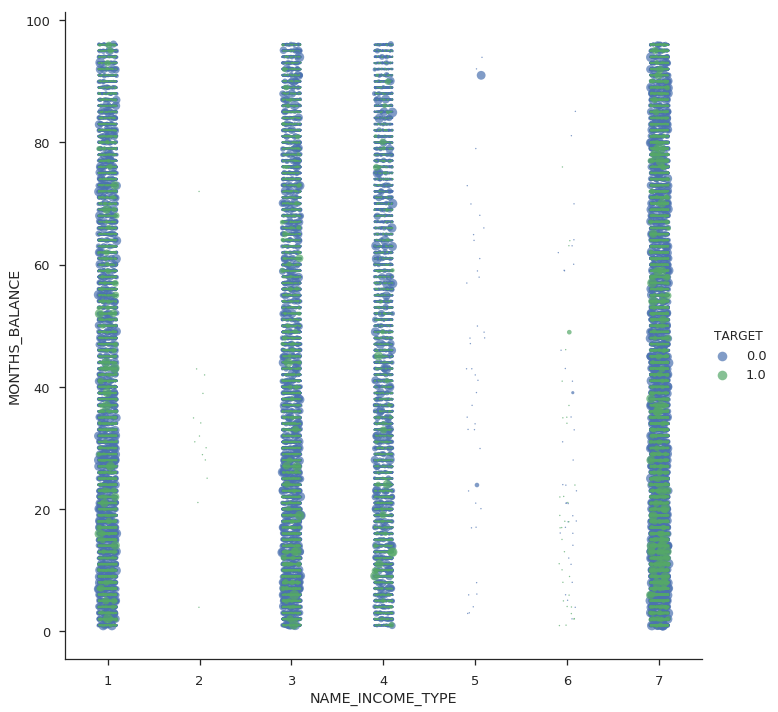

In [67]:
sns.lmplot(x='NAME_INCOME_TYPE',
           y='MONTHS_BALANCE',
           hue='TARGET',
           data=x,
           fit_reg=False,  # do not fit a regression line
           x_jitter=0.1,   # could also dynamically set this with range of data
           y_jitter=0.1,
           size=10,
           scatter_kws={'alpha': 0.7, 's': x.SK_DPD + 2});

In [138]:
%%time
mask = (prev_app.NAME_CONTRACT_STATUS == 'Approved') & ((prev_app.DAYS_TERMINATION.notnull()) &\
       (prev_app.DAYS_TERMINATION != prev_app.DAYS_TERMINATION.max()))

tmp = prev_app.loc[mask, ['SK_ID_CURR', 'DAYS_DECISION', 'DAYS_TERMINATION', 'AMT_CREDIT']]
tmp.loc[:, 'duration'] = tmp.DAYS_TERMINATION  - tmp.DAYS_DECISION 

tmp = app_train.loc[:, ['SK_ID_CURR', 'NAME_INCOME_TYPE', 'AMT_INCOME_TOTAL', 'TARGET']]\
               .merge(tmp.loc[:, ['SK_ID_CURR',
                                  'DAYS_DECISION',
                                  'duration',
                                  'AMT_CREDIT'
                                 ]], on='SK_ID_CURR', how='inner')

tmp.loc[:, 'NAME_INCOME_TYPE'] = tmp.NAME_INCOME_TYPE.cat.codes.astype(np.int)
tmp.loc[:, 'DAYS_DECISION']    = -tmp.DAYS_DECISION
tmp.loc[:, 'ratio']            = tmp.AMT_CREDIT / tmp.AMT_INCOME_TOTAL

print(tmp.head())

   SK_ID_CURR  NAME_INCOME_TYPE  AMT_INCOME_TOTAL  TARGET  DAYS_DECISION  \
0      100002                 7          202500.0     1.0            606   
1      100003                 4          270000.0     0.0            746   
2      100003                 4          270000.0     0.0            828   
3      100003                 4          270000.0     0.0           2341   
4      100004                 7           67500.0     0.0            815   

   duration  AMT_CREDIT     ratio  
0     589.0    179055.0  0.884222  
1     219.0   1035882.0  3.836600  
2     189.0    348637.5  1.291250  
3     365.0     68053.5  0.252050  
4     101.0     20106.0  0.297867  
CPU times: user 345 ms, sys: 0 ns, total: 345 ms
Wall time: 339 ms


In [149]:
tmp.shape

(658595, 8)

In [150]:
x = tmp[tmp.duration < 500].sample(n=100000)

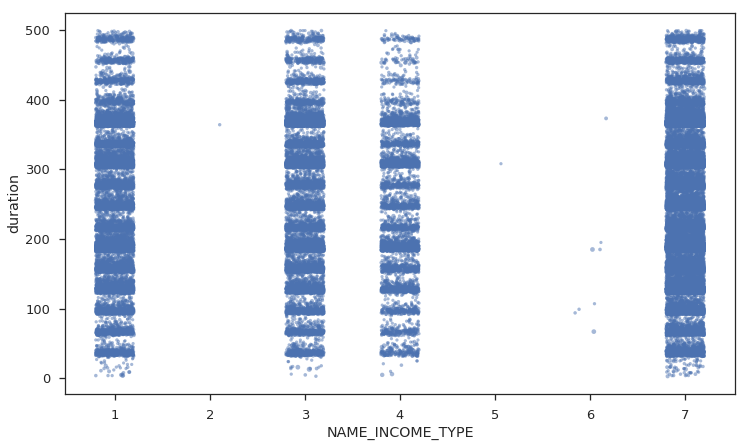

In [151]:
plt.figure(figsize=(12, 7))

sns.regplot(x='NAME_INCOME_TYPE',
            y='duration',
            data=x,
            fit_reg=False,  # do not fit a regression line
            x_jitter=0.2,   # could also dynamically set this with range of data
            y_jitter=0.1,
            scatter_kws={'alpha': 0.5, 's': x.ratio + 10});

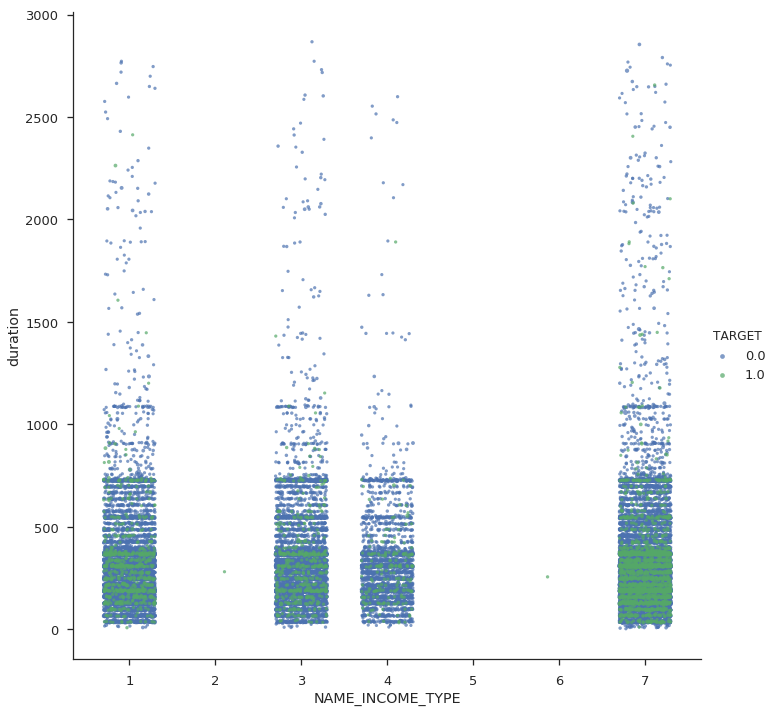

In [143]:
sns.lmplot(x='NAME_INCOME_TYPE',
           y='duration',
           hue='TARGET',
           data=x,
           fit_reg=False,  # do not fit a regression line
           x_jitter=0.3,   # could also dynamically set this with range of data
           y_jitter=0.1,
           size=10,
           scatter_kws={'alpha': 0.7, 's': x.ratio + 10});

### Difference between train and test

In [51]:
tmp = pd.concat((app_train.loc[:, ['EXT_SOURCE_3', 'DAYS_BIRTH']],
                 app_test.loc[:, ['EXT_SOURCE_3', 'DAYS_BIRTH']]
                ))

tmp.loc[:, 'is_train'] = [1] * len(tmp)
tmp.iloc[len(app_train):].loc[:, 'is_train'] = 0
# tmp.loc[:, 'ratio'] = tmp.loc[:, 'AMT_CREDIT'] / tmp.loc[:, 'AMT_ANNUITY']
tmp.loc[:, 'age']   = (-tmp.DAYS_BIRTH / 365)

tmp.head()

,EXT_SOURCE_3,DAYS_BIRTH,is_train,age
0,0.139404,-9461,1,25.920548
1,NaN,-16765,1,45.931507
2,0.729492,-19046,1,52.180822
3,NaN,-19005,1,52.068493
4,NaN,-19932,1,54.608219


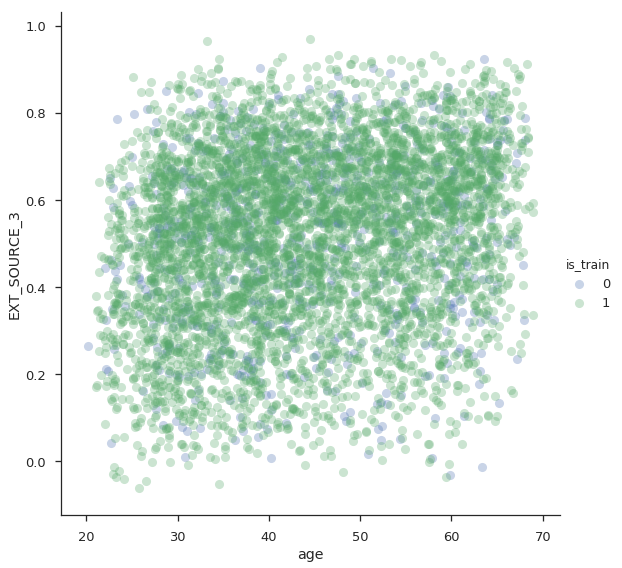

In [56]:
sns.lmplot(x='age', 
           y='EXT_SOURCE_3', 
           data=tmp.sample(n=7000), 
           fit_reg=False, 
           size=8,
           x_jitter=0.1,   # could also dynamically set this with range of data
           y_jitter=0.1, 
           hue='is_train',
           scatter_kws={'alpha': .3}
          );

In [57]:
app_train.columns.tolist()

['AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'CNT_CHILDREN',
 'CNT_FAM_MEMBERS',
 'CODE_GENDER',
 'COMMONAREA_AVG',
 'COMMONAREA_MEDI',
 'COMMONAREA_MODE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'ELEVATORS_AVG',
 'ELEVATORS_MEDI',
 'ELEVATORS_MODE',
 'EMERGENCYSTATE_MODE',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT

In [74]:
pd.crosstab(app_train.NAME_FAMILY_STATUS.astype(np.str), 
            app_train.NAME_INCOME_TYPE.astype(np.str)
           )

NAME_INCOME_TYPE,Businessman,Commercial associate,Maternity leave,Pensioner,State servant,Student,Unemployed,Working
NAME_FAMILY_STATUS,,,,,,,,
Civil marriage,1,7717,0,3577,1747,4,3,16726
Married,7,45489,5,32511,15112,9,10,103289
Separated,0,4537,0,3771,1361,1,1,10099
Single / not married,2,12237,0,6124,2785,4,5,24287
Unknown,0,2,0,0,0,0,0,0
Widow,0,1635,0,9379,698,0,3,4373


In [59]:
app_train.NAME_INCOME_TYPE.value_counts()

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

### Target Mean Encoding

In [56]:
%run ../src/base.py

In [57]:
from sklearn.model_selection import cross_val_predict

In [58]:
cat_features = ['NAME_INCOME_TYPE', 'OCCUPATION_TYPE']
df = app_train.loc[:, cat_features + ['TARGET']]

for col in cat_features:
    df[col] = df[col].cat.codes
    
print(df.head())

   NAME_INCOME_TYPE  OCCUPATION_TYPE  TARGET
0                 7                8     1.0
1                 4                3     0.0
2                 7                8     0.0
3                 7                8     0.0
4                 7                3     0.0


In [59]:
cme = CategoricalMeanEncoded(categorical_features=cat_features)
pp  = df.sample(n=1000)
res = cross_val_predict(cme, pp, pp.loc[:, df.columns.drop('TARGET')], n_jobs=1)

In [61]:
res.shape

(1000, 2)

In [34]:
dtr, dte, _, _ = train_test_split(df, df.TARGET, stratify=df.TARGET, test_size=.3, random_state=SEED)
print(dtr.shape, ' ', dte.shape)

(215257, 3)   (92254, 3)


In [35]:
cme = CategoricalMeanEncoded()
cme.fit_transform(dtr, cat_features)

array([[0.09655271, 0.10049278],
       [0.07718977, 0.10710056],
       [0.05645763, 0.06645776],
       ...,
       [0.05645763, 0.06645776],
       [0.07718977, 0.26351714],
       [0.07718977, 0.06231156]], dtype=float32)

In [36]:
cme.transform(dte, cat_features)

array([[0.09569   , 0.10473199],
       [0.05409022, 0.06509785],
       [0.09569   , 0.10473199],
       ...,
       [0.07535666, 0.10473199],
       [0.09569   , 0.10854176],
       [0.07535666, 0.09644491]], dtype=float32)

### Group credits by duration

In [7]:
tmp  = app_train.loc[:, ['SK_ID_CURR', 'TARGET']]\
                .merge(bureau.loc[:, ['SK_ID_CURR', 'DAYS_CREDIT']],
                       on='SK_ID_CURR',
                       how='left'
                      )

tmp.shape

(1509345, 3)

In [8]:
tmp.loc[:, 'credit_years'] = -tmp.DAYS_CREDIT / 365
tmp.head()

,SK_ID_CURR,TARGET,DAYS_CREDIT,credit_years
0,100002,1.0,-1125.0,3.082192
1,100002,1.0,-476.0,1.304110
2,100002,1.0,-1437.0,3.936986
3,100002,1.0,-1121.0,3.071233
4,100002,1.0,-645.0,1.767123


In [9]:
tmp.credit_years.describe()

count    1.465325e+06
mean     3.133152e+00
std      2.191836e+00
min     -0.000000e+00
25%      1.287671e+00
50%      2.698630e+00
75%      4.578082e+00
max      8.005479e+00
Name: credit_years, dtype: float64

In [10]:
tmp.loc[:, 'credit_years_cat'] = pd.factorize(pd.cut(tmp.credit_years, 
                                                     bins=[0, 0.25, .5, .75, 1, 2, 3, 4, 5, 6, 7, 8, 9]))[0]

In [31]:
res = tmp.groupby(['SK_ID_CURR', 'credit_years_cat']).size().unstack().fillna(0).reset_index()\
         .merge(app_train.loc[:, ['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')
    
res.head()

,SK_ID_CURR,-1,0,1,2,3,4,5,6,7,8,9,10,11,TARGET
0,100002,0.0,3.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


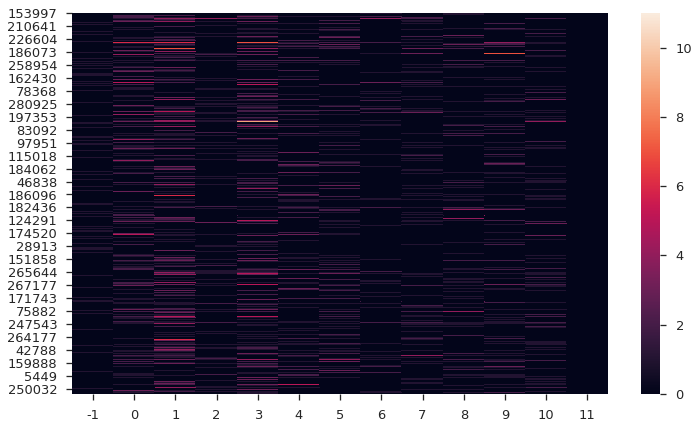

In [34]:
plt.figure(figsize=(12, 7))
sns.heatmap(res[res.TARGET == 0].iloc[:, 1:-1].sample(n=1000));

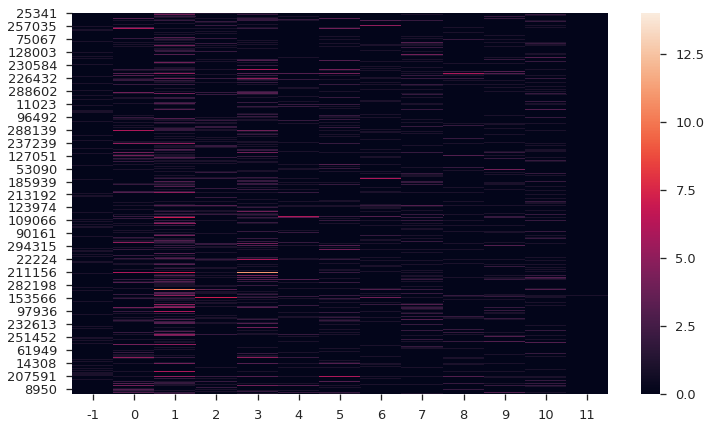

In [36]:
plt.figure(figsize=(12, 7))
sns.heatmap(res[res.TARGET == 1].iloc[:, 1:-1].sample(n=1000));

In [199]:
tmp  = app_train.loc[:, ['SK_ID_CURR', 'TARGET']]\
                .merge(bureau.loc[:, ['SK_ID_CURR', 'DAYS_CREDIT', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT']],
                       on='SK_ID_CURR',
                       how='left'
                      )

tmp.loc[:, 'credit_years'] = -tmp.DAYS_CREDIT / 365
tmp.head()

,SK_ID_CURR,TARGET,DAYS_CREDIT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,credit_years
0,100002,1.0,-1125.0,40761.0,NaN,3.082192
1,100002,1.0,-476.0,0.0,0.0,1.304110
2,100002,1.0,-1437.0,135000.0,0.0,3.936986
3,100002,1.0,-1121.0,19071.0,NaN,3.071233
4,100002,1.0,-645.0,120735.0,0.0,1.767123


In [200]:
tmp.loc[:, 'credit_years_cat'] = pd.factorize(pd.cut(tmp.credit_years, 
                                                     bins=[0, 0.25, .5, .75, 1, 2, 3, 4, 5, 6, 7, 8, 9]))[0]

In [203]:
res = (tmp.groupby(['SK_ID_CURR', 'credit_years_cat'])['AMT_CREDIT_SUM_DEBT'].sum() / tmp.groupby(['SK_ID_CURR', 'credit_years_cat'])['AMT_CREDIT_SUM'].sum()).unstack().fillna(0).reset_index()\
         .merge(app_train.loc[:, ['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')
    
res.head()

,SK_ID_CURR,-1,0,1,2,3,4,5,6,7,8,9,10,11,TARGET
0,100002,0.0,0.0,0.0,0.0,0.474939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


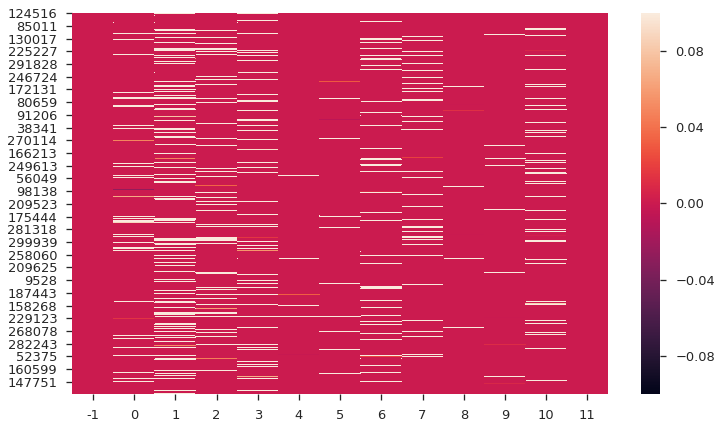

In [208]:
plt.figure(figsize=(12, 7))
x = res[res.TARGET == 0].iloc[:, 1:-1].sample(n=5000)
# pd.DataFrame(x.values / x.sum(axis=1).values[:, None], columns=x.columns)
sns.heatmap(x);

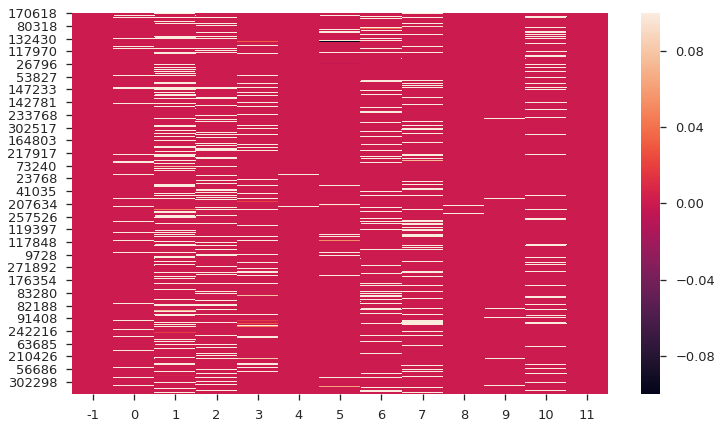

In [209]:
plt.figure(figsize=(12, 7))
x = res[res.TARGET == 1].iloc[:, 1:-1].sample(n=5000)
# pd.DataFrame(x.values / x.sum(axis=1).values[:, None], columns=x.columns)
sns.heatmap(x);

In [42]:
tmp  = app_train.loc[:, ['SK_ID_CURR', 'TARGET']]\
                .merge(bureau.loc[:, ['SK_ID_CURR', 'CREDIT_ACTIVE']],
                       on='SK_ID_CURR',
                       how='left'
                      )

tmp.loc[:, 'CREDIT_ACTIVE'] = tmp.CREDIT_ACTIVE.astype(np.str)
tmp.shape

(1509345, 3)

In [43]:
res = tmp.groupby(['SK_ID_CURR', 'CREDIT_ACTIVE']).size().unstack().fillna(0).reset_index()\
         .merge(app_train.loc[:, ['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')
    
res.head()

,SK_ID_CURR,Active,Bad debt,Closed,Sold,nan,TARGET
0,100002,2.0,0.0,6.0,0.0,0.0,1.0
1,100003,1.0,0.0,3.0,0.0,0.0,0.0
2,100004,0.0,0.0,2.0,0.0,0.0,0.0
3,100006,0.0,0.0,0.0,0.0,1.0,0.0
4,100007,0.0,0.0,1.0,0.0,0.0,0.0


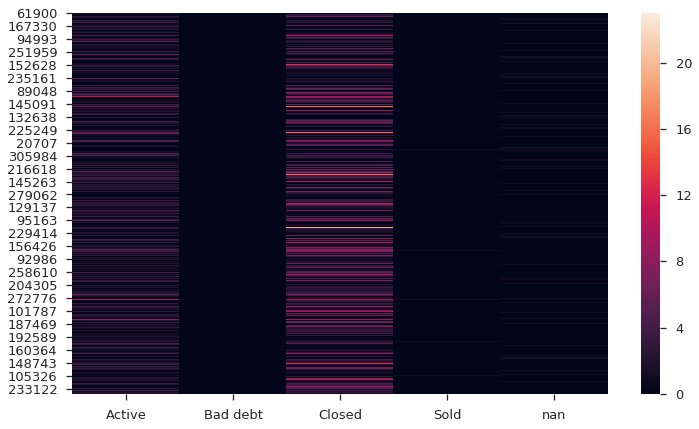

In [44]:
plt.figure(figsize=(12, 7))
sns.heatmap(res[res.TARGET == 0].iloc[:, 1:-1].sample(n=1000));

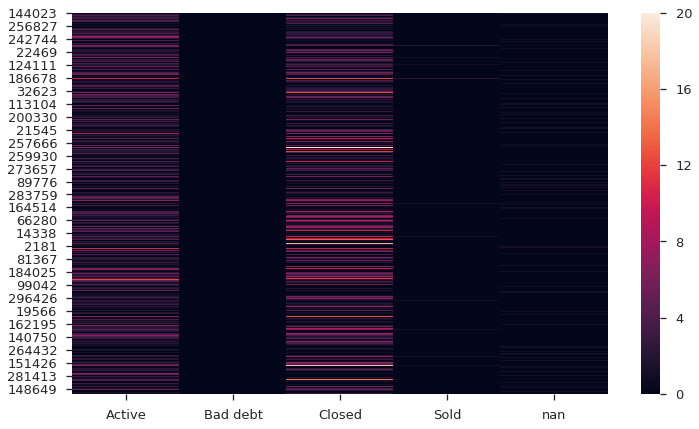

In [45]:
plt.figure(figsize=(12, 7))
sns.heatmap(res[res.TARGET == 1].iloc[:, 1:-1].sample(n=1000));

In [47]:
tmp  = app_train.loc[:, ['SK_ID_CURR', 'TARGET']]\
                .merge(bureau.loc[:, ['SK_ID_CURR', 'CREDIT_TYPE']],
                       on='SK_ID_CURR',
                       how='left'
                      )

tmp.loc[:, 'CREDIT_TYPE'] = tmp.CREDIT_TYPE.astype(np.str)
tmp.shape

(1509345, 3)

In [48]:
res = tmp.groupby(['SK_ID_CURR', 'CREDIT_TYPE']).size().unstack().fillna(0).reset_index()\
         .merge(app_train.loc[:, ['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')
    
res.head()

,SK_ID_CURR,Another type of loan,Car loan,Cash loan (non-earmarked),Consumer credit,Credit card,Interbank credit,Loan for business development,Loan for purchase of shares (margin lending),Loan for the purchase of equipment,Loan for working capital replenishment,Microloan,Mobile operator loan,Mortgage,Real estate loan,Unknown type of loan,nan,TARGET
0,100002,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,100007,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


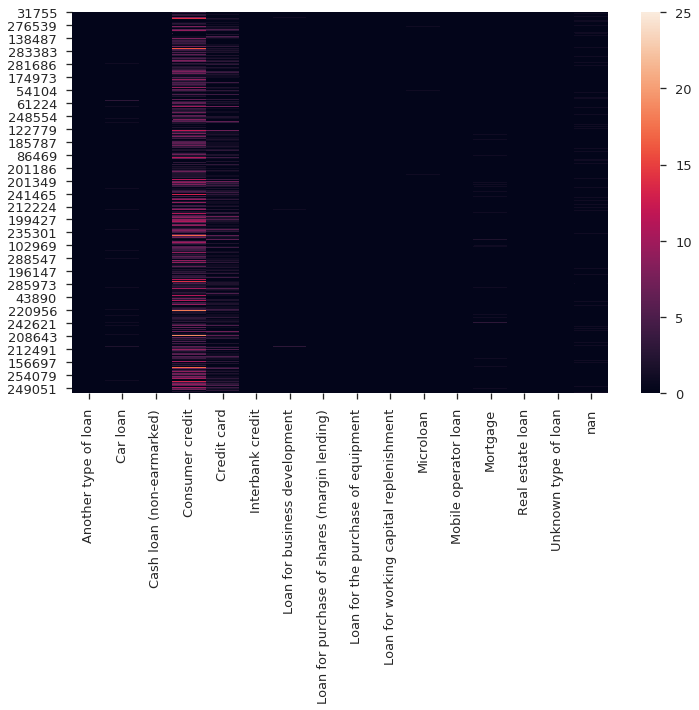

In [54]:
plt.figure(figsize=(12, 7))
sns.heatmap(res[res.TARGET == 0].iloc[:, 1:-1].sample(n=1000));

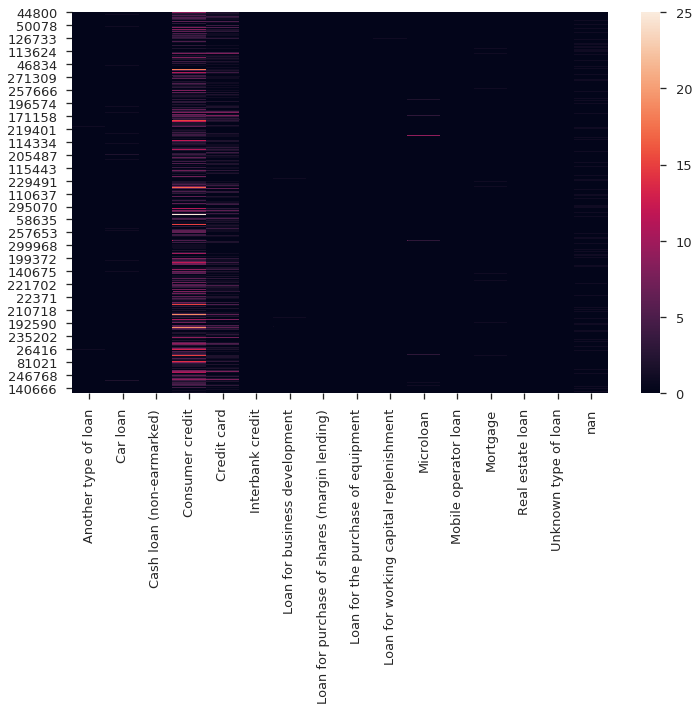

In [55]:
plt.figure(figsize=(12, 7))
sns.heatmap(res[res.TARGET == 1].iloc[:, 1:-1].sample(n=1000));

In [86]:
def get_nth_dpd(n):
    tmp = pos_cash.loc[pos_cash.MONTHS_BALANCE == -n, ['SK_ID_CURR', 'SK_DPD']]\
                  .groupby(['SK_ID_CURR'])['SK_DPD'].sum().reset_index()

    tmp = app_train.loc[:, ['SK_ID_CURR']].merge(tmp,
                    on='SK_ID_CURR',
                    how='left'
                   )
    tmp.columns = ['SK_ID_CURR', f'DPD_{n}']
    
    return tmp

    
_1_tmp  = get_nth_dpd(n=1)
_2_tmp  = get_nth_dpd(n=2)
_3_tmp  = get_nth_dpd(n=3)
_4_tmp  = get_nth_dpd(n=4)
_5_tmp  = get_nth_dpd(n=5)
_6_tmp  = get_nth_dpd(n=6)
_7_tmp  = get_nth_dpd(n=7)
_8_tmp  = get_nth_dpd(n=8)
_9_tmp  = get_nth_dpd(n=9)
_10_tmp = get_nth_dpd(n=10)
_11_tmp = get_nth_dpd(n=11)
_12_tmp = get_nth_dpd(n=12)
_13_tmp = get_nth_dpd(n=13)
_14_tmp = get_nth_dpd(n=14)
_15_tmp = get_nth_dpd(n=15)
_16_tmp = get_nth_dpd(n=16)
_17_tmp = get_nth_dpd(n=17)
_18_tmp = get_nth_dpd(n=18)
_19_tmp = get_nth_dpd(n=19)
_20_tmp = get_nth_dpd(n=20)
_21_tmp = get_nth_dpd(n=21)
_22_tmp = get_nth_dpd(n=22)
_23_tmp = get_nth_dpd(n=23)
_24_tmp = get_nth_dpd(n=24)

In [87]:
res = pd.concat((_1_tmp, 
           _2_tmp.drop('SK_ID_CURR', axis=1),
           _3_tmp.drop('SK_ID_CURR', axis=1),
           _4_tmp.drop('SK_ID_CURR', axis=1),
           _5_tmp.drop('SK_ID_CURR', axis=1),
           _6_tmp.drop('SK_ID_CURR', axis=1),
           _7_tmp.drop('SK_ID_CURR', axis=1),
           _8_tmp.drop('SK_ID_CURR', axis=1),
           _9_tmp.drop('SK_ID_CURR', axis=1),
           _10_tmp.drop('SK_ID_CURR', axis=1),
           _11_tmp.drop('SK_ID_CURR', axis=1),
           _12_tmp.drop('SK_ID_CURR', axis=1),
           _13_tmp.drop('SK_ID_CURR', axis=1),
           _14_tmp.drop('SK_ID_CURR', axis=1),
           _15_tmp.drop('SK_ID_CURR', axis=1),
           _16_tmp.drop('SK_ID_CURR', axis=1),
           _17_tmp.drop('SK_ID_CURR', axis=1),
           _18_tmp.drop('SK_ID_CURR', axis=1),
           _19_tmp.drop('SK_ID_CURR', axis=1),
           _20_tmp.drop('SK_ID_CURR', axis=1),
           _21_tmp.drop('SK_ID_CURR', axis=1),
           _22_tmp.drop('SK_ID_CURR', axis=1),
           _23_tmp.drop('SK_ID_CURR', axis=1),
           _24_tmp.drop('SK_ID_CURR', axis=1)
          ), axis=1)

res = app_train.loc[:, ['SK_ID_CURR', 'TARGET']].merge(res, on='SK_ID_CURR', how='left')

res.head()

,SK_ID_CURR,TARGET,DPD_1,DPD_2,DPD_3,DPD_4,DPD_5,DPD_6,DPD_7,DPD_8,...,DPD_15,DPD_16,DPD_17,DPD_18,DPD_19,DPD_20,DPD_21,DPD_22,DPD_23,DPD_24
0,100002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,100006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,100007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


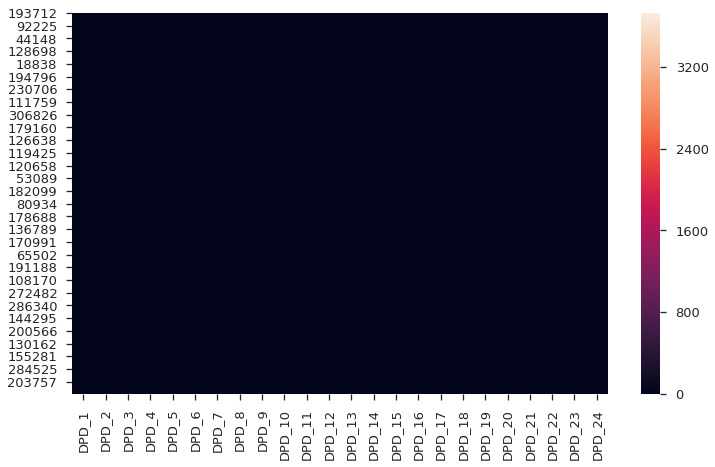

In [94]:
plt.figure(figsize=(12, 7))
sns.heatmap(res[res.TARGET == 0].iloc[:, 2:].fillna(0).sample(n=10000));

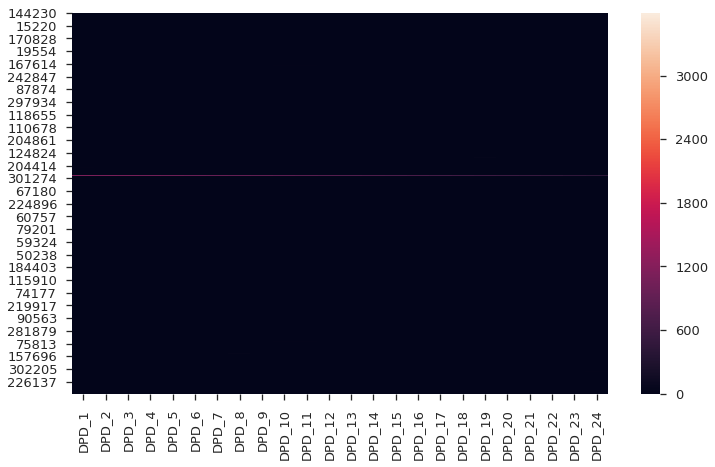

In [95]:
plt.figure(figsize=(12, 7))
sns.heatmap(res[res.TARGET == 1].iloc[:, 2:].fillna(0).sample(n=10000));

### Bureau and Bureau Balance

In [44]:
tmp = bureau_bal.loc[bureau_bal.MONTHS_BALANCE >= -12, ['SK_ID_BUREAU', 'STATUS']]\
                .merge(bureau.loc[:, ['SK_ID_CURR', 'SK_ID_BUREAU']], on='SK_ID_BUREAU', how='inner')
tmp.loc[:, 'STATUS'] = tmp.STATUS.astype(np.str)
tmp.head()

,SK_ID_BUREAU,STATUS,SK_ID_CURR
0,5715448,C,380361
1,5715448,C,380361
2,5715448,C,380361
3,5715448,C,380361
4,5715448,C,380361


In [45]:
res = tmp.groupby(['SK_ID_CURR', 'STATUS']).size().unstack().fillna(0).reset_index()
res = app_train.loc[:, ['SK_ID_CURR', 'TARGET']].merge(res, on='SK_ID_CURR', how='left')

res.head()

,SK_ID_CURR,TARGET,0,1,2,3,4,5,C,X
0,100002,1.0,2.0,0.0,0.0,0.0,0.0,0.0,13.0,2.0
1,100003,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


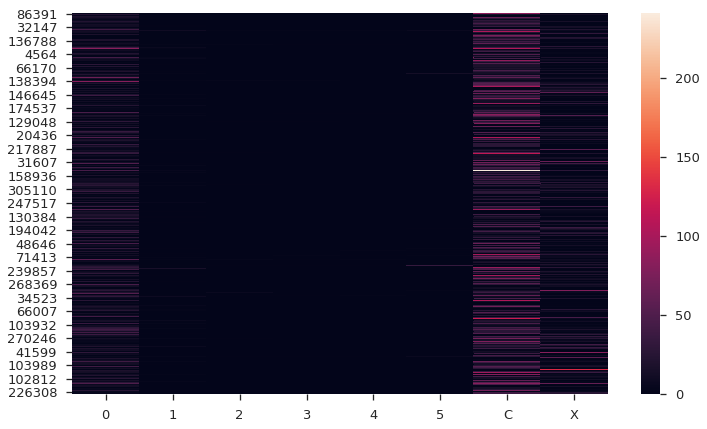

In [46]:
plt.figure(figsize=(12, 7))

sns.heatmap(res[res.TARGET == 0].sample(n=1500).iloc[:, 2:].dropna());

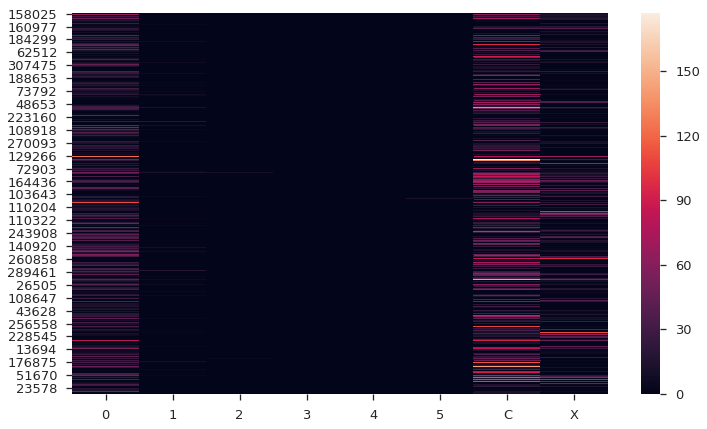

In [47]:
plt.figure(figsize=(12, 7))

sns.heatmap(res[res.TARGET == 1].sample(n=1500).iloc[:, 2:].dropna());

### DPD by Version Number

In [6]:
def get_instalments_dpd():
    mask = (installments.DAYS_ENTRY_PAYMENT > installments.DAYS_INSTALMENT)
    return installments.loc[mask, ['SK_ID_CURR', 'NUM_INSTALMENT_NUMBER']]
    
    
dpd_install = get_instalments_dpd()

In [7]:
tmp = dpd_install.groupby(['SK_ID_CURR', 'NUM_INSTALMENT_NUMBER']).size().unstack().fillna(0).reset_index()
tmp.head()

NUM_INSTALMENT_NUMBER,SK_ID_CURR,1,2,3,4,5,6,7,8,9,...,208,210,211,212,213,214,215,218,227,230
0,100001,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100007,2.0,1.0,1.0,1.0,2.0,2.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100009,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
tmp = app_train.loc[:, ['SK_ID_CURR', 'TARGET']].merge(tmp, on='SK_ID_CURR', how='left')
tmp.shape

(307511, 215)

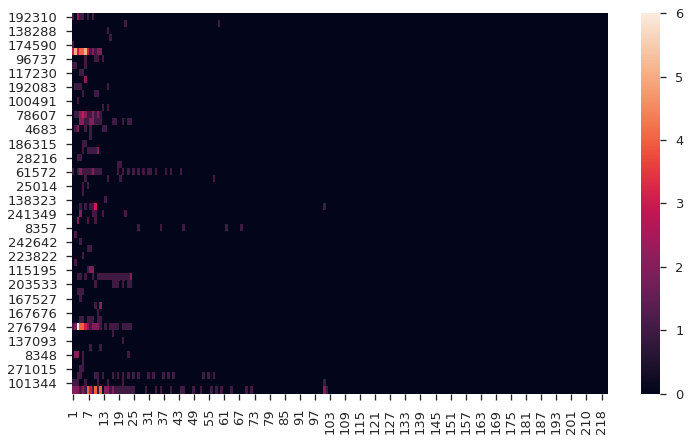

In [10]:
plt.figure(figsize=(12, 7))
sns.heatmap(tmp[tmp.TARGET == 0].sample(n=100).iloc[:, 2:].dropna());

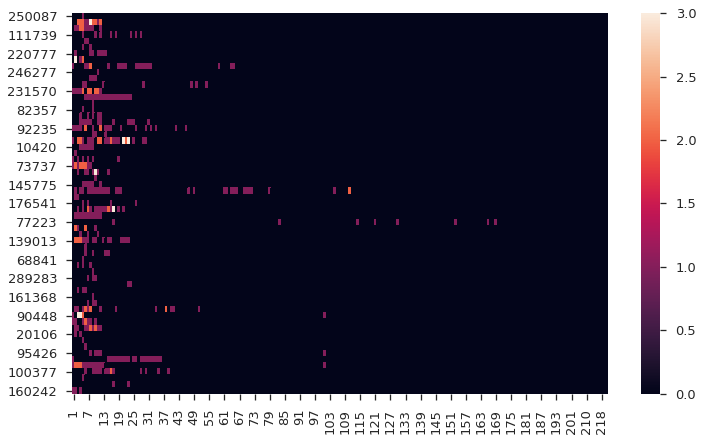

In [11]:
plt.figure(figsize=(12, 7))
sns.heatmap(tmp[tmp.TARGET == 1].sample(n=100).iloc[:, 2:].dropna());

In [7]:
def get_amount_dpd():
    mask = (installments.AMT_INSTALMENT > installments.AMT_PAYMENT)
    return installments.loc[mask, ['SK_ID_CURR', 'NUM_INSTALMENT_NUMBER']]
    
    
dpd_install = get_amount_dpd()

In [8]:
tmp = dpd_install.groupby(['SK_ID_CURR', 'NUM_INSTALMENT_NUMBER']).size().unstack().fillna(0).reset_index()
tmp.head()

NUM_INSTALMENT_NUMBER,SK_ID_CURR,1,2,3,4,5,6,7,8,9,...,222,234,237,239,245,254,256,262,264,268
0,100007,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100012,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100013,0.0,2.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
tmp = app_train.loc[:, ['SK_ID_CURR', 'TARGET']].merge(tmp, on='SK_ID_CURR', how='left')
tmp.shape

(307511, 224)

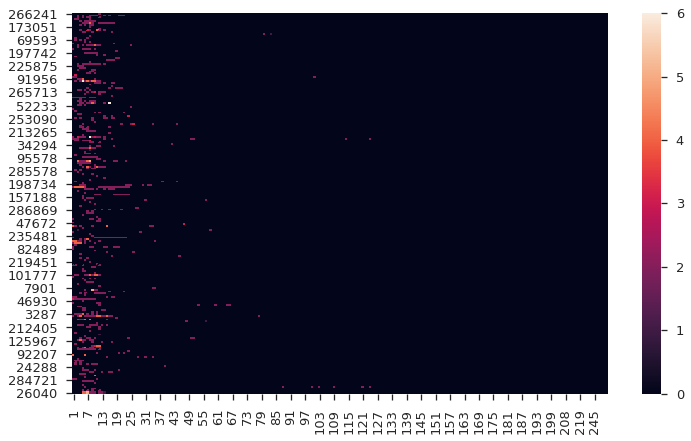

In [13]:
plt.figure(figsize=(12, 7))
sns.heatmap(tmp[tmp.TARGET == 0].sample(n=500).iloc[:, 2:].dropna());

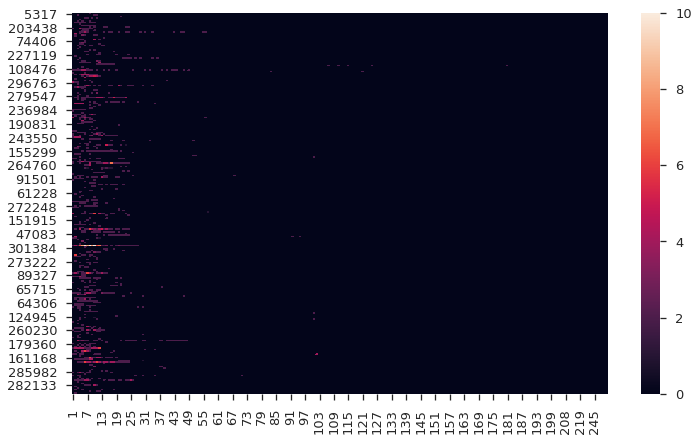

In [14]:
plt.figure(figsize=(12, 7))
sns.heatmap(tmp[tmp.TARGET == 1].sample(n=500).iloc[:, 2:].dropna());

### String Entropy

In [6]:
def count_in_str(x, ch, deg=1):
    return (sum((1./t ** deg for t, c in enumerate(x, start=1) if c==ch)) / (0.01 + sum((1./t ** deg for t in range(1, 1+len(x))))))

In [7]:
%%time

tmp = bureau.loc[:, ['SK_ID_CURR', 'SK_ID_BUREAU']]\
            .merge(bureau_bal.loc[bureau_bal.MONTHS_BALANCE >= -12, ['SK_ID_BUREAU', 'STATUS']], on='SK_ID_BUREAU', how='inner')

CPU times: user 884 ms, sys: 358 ms, total: 1.24 s
Wall time: 1.25 s


In [8]:
%%time

count         = 0
sk_id_currs   = []
entropy_chars = []

for name, group in tmp.groupby('SK_ID_CURR'):
    status_line  = ''.join(group.STATUS.values)
    sk_id_currs.append(group.SK_ID_CURR.values[0])
    
    possible_status = ['0', '1', '2', '3', '4', '5', 'X', 'C']
    for deg in [1, 2, 3]:
        entropy_chars.append([count_in_str(status_line, char_, deg=deg) for char_ in possible_status])

CPU times: user 2min 37s, sys: 551 ms, total: 2min 37s
Wall time: 2min 37s


In [15]:
len(sk_id_currs)

132366

In [13]:
np.hstack(entropy_chars).shape

(3176784,)

In [9]:
entropy = pd.DataFrame(np.hstack((np.array(sk_id_currs)[:, None], entropy_chars)))

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [16]:
tmp = app_train.loc[:, ['SK_ID_CURR', 'TARGET']].merge(entropy, on='SK_ID_CURR', how='left')
print(tmp.shape)
print(tmp.head(2))

(307511, 10)
   SK_ID_CURR  TARGET         0    1    2    3    4    5        X         C
0      100002     1.0  0.000546  0.0  0.0  0.0  0.0  0.0  0.00037  0.990823
1      100003     0.0       NaN  NaN  NaN  NaN  NaN  NaN      NaN       NaN


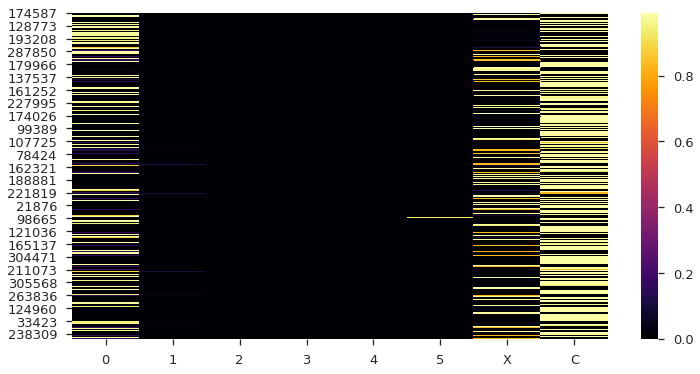

In [19]:
plt.figure(figsize=(12, 6))
sns.heatmap(tmp[tmp.TARGET == 0].sample(n=2000).iloc[:, 2:].dropna(), cmap='inferno');

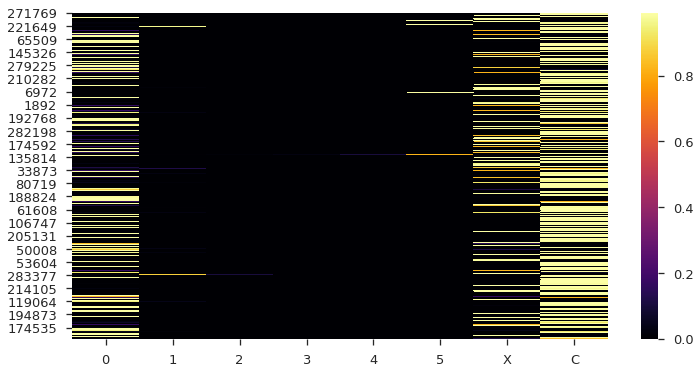

In [20]:
plt.figure(figsize=(12, 6))
sns.heatmap(tmp[tmp.TARGET == 1].sample(n=2000).iloc[:, 2:].dropna(), cmap='inferno');

In [63]:
installments.head().T

,0,1,2,3,4
SK_ID_PREV,1.054186e+06,1.330831e+06,2085231.0,2.452527e+06,2.714724e+06
SK_ID_CURR,1.616740e+05,1.516390e+05,193053.0,1.996970e+05,1.677560e+05
NUM_INSTALMENT_VERSION,1.000000e+00,0.000000e+00,2.0,1.000000e+00,1.000000e+00
NUM_INSTALMENT_NUMBER,6.000000e+00,3.400000e+01,1.0,3.000000e+00,2.000000e+00
DAYS_INSTALMENT,-1.180000e+03,-2.156000e+03,-63.0,-2.418000e+03,-1.383000e+03
DAYS_ENTRY_PAYMENT,-1.187000e+03,-2.156000e+03,-63.0,-2.426000e+03,-1.366000e+03
AMT_INSTALMENT,6.948360e+03,1.716525e+03,25425.0,2.435013e+04,2.165040e+03
AMT_PAYMENT,6.948360e+03,1.716525e+03,25425.0,2.435013e+04,2.160585e+03


In [90]:
mask = (prev_app.NAME_CONTRACT_STATUS == 'Approved') & (prev_app.DAYS_TERMINATION < 0)

t    = installments.groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index=False)['AMT_PAYMENT'].sum()

tmp  = prev_app.loc[mask, ['SK_ID_CURR', 'SK_ID_PREV', 'AMT_CREDIT', 'CNT_PAYMENT']]\
        .merge(t,
               on=['SK_ID_CURR', 'SK_ID_PREV'],
               how='left'
              )
print(tmp.shape)

(771236, 5)


In [91]:
tmp.loc[:, 'diff_lend_paid']         = tmp.AMT_PAYMENT / tmp.CNT_PAYMENT
tmp.loc[:, 'diff_lend_paid_to_lend'] = tmp.diff_lend_paid / tmp.AMT_CREDIT

tmp.loc[:, 'paid_less_than_credit']  = (tmp.diff_lend_paid > 0).astype(np.uint8)

In [92]:
diff_lend_paid = tmp.groupby('SK_ID_CURR')['diff_lend_paid'].sum()
diff_lend_paid_to_credit = tmp.groupby('SK_ID_CURR')['diff_lend_paid_to_lend'].sum()
paid_less_than_credit = tmp.groupby('SK_ID_CURR')['paid_less_than_credit'].sum()

In [93]:
res = app_train.SK_ID_CURR.map(diff_lend_paid)

In [94]:
res[res.isnull()].shape[0] / len(res)

0.1316928500118695

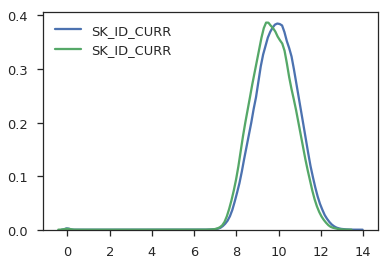

In [95]:
sns.kdeplot(res[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(res[app_train.TARGET == 1].map(np.log1p));

In [169]:
# x = installments.loc[installments.DAYS_ENTRY_PAYMENT > installments.DAYS_INSTALMENT,]
# x = (x.DAYS_ENTRY_PAYMENT - x.DAYS_INSTALMENT).groupby([x.SK_ID_CURR, x.SK_ID_PREV]).sum()\
#     .reset_index().rename(columns={0: 'SK_DPD'})
# x = prev_app.loc[:, ['SK_ID_CURR', 'SK_ID_PREV', 'DAYS_DECISION']].merge(x, on=['SK_ID_CURR', 'SK_ID_PREV'], how='left')

x = installments.groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index=False)['AMT_PAYMENT'].sum()
x = prev_app.loc[(prev_app.NAME_CONTRACT_STATUS == 'Approved'), 
                 ['SK_ID_CURR', 'SK_ID_PREV', 'DAYS_DECISION']]\
            .merge(x, on=['SK_ID_CURR', 'SK_ID_PREV'], how='left')

In [171]:
tmp  = app_train.loc[:, ['SK_ID_CURR', 'TARGET']]\
                .merge(x,
                       on='SK_ID_CURR',
                       how='left'
                      )

tmp.loc[:, 'credit_years'] = -tmp.DAYS_DECISION / 365
tmp.head()

,SK_ID_CURR,TARGET,SK_ID_PREV,DAYS_DECISION,AMT_PAYMENT,credit_years
0,100002,1.0,1038818.0,-606.0,2.196257e+05,1.660274
1,100003,0.0,1810518.0,-746.0,1.150977e+06,2.043836
2,100003,0.0,2636178.0,-828.0,3.871139e+05,2.268493
3,100003,0.0,2396755.0,-2341.0,8.077338e+04,6.413699
4,100004,0.0,1564014.0,-815.0,2.128846e+04,2.232877


In [172]:
tmp.loc[:, 'credit_years_cat'] = pd.factorize(pd.cut(tmp.credit_years, 
                                                     bins=[0, 0.25, .5, .75, 1, 2, 3, 4, 5, 6, 7, 8, 9]))[0]

In [173]:
res = tmp.groupby(['SK_ID_CURR', 'credit_years_cat'])['AMT_PAYMENT'].sum().unstack().fillna(0).reset_index()\
         .merge(app_train.loc[:, ['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')
    
res.head()

,SK_ID_CURR,-1,0,1,2,3,4,5,6,7,8,9,10,11,TARGET
0,100002,0.0,219625.703125,0.000000e+00,0.000000,0.000,0.0000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0.0,0.000000,1.538091e+06,80773.382812,0.000,0.0000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,0.000000,2.128846e+04,0.000000,0.000,0.0000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,25091.324219,0.000000e+00,0.000000,691786.875,290275.1875,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0.0,192451.671875,2.801997e+05,18330.390625,0.000,0.0000,43193.878906,271952.3125,0.0,0.0,0.0,0.0,0.0,0.0


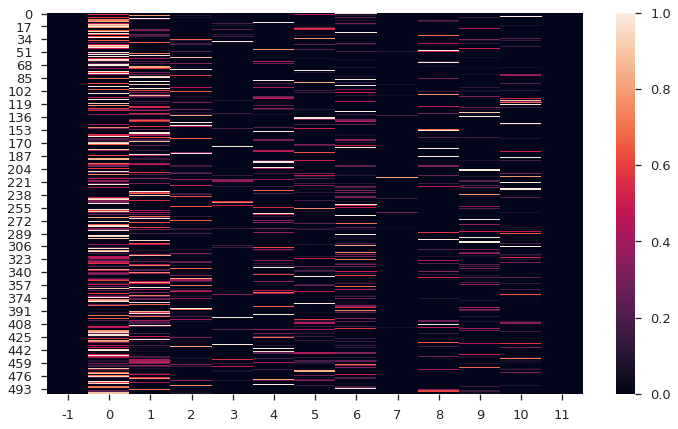

In [178]:
plt.figure(figsize=(12, 7))
x = res[res.TARGET == 0].iloc[:, 1:-1].sample(n=500)

sns.heatmap(pd.DataFrame(x.values / x.sum(axis=1).values[:, None], columns=x.columns));

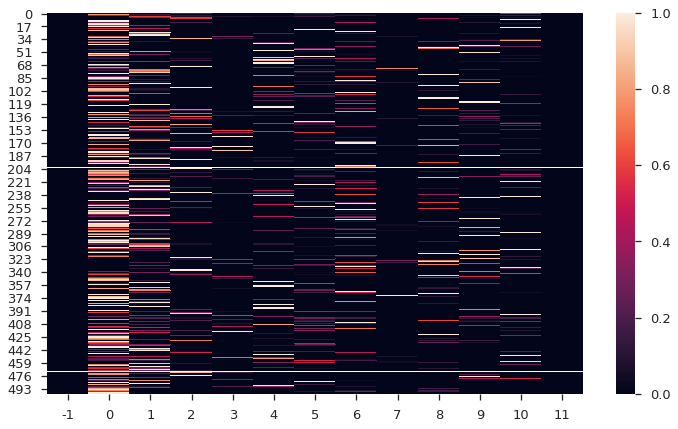

In [179]:
plt.figure(figsize=(12, 7))
x = res[res.TARGET == 1].iloc[:, 1:-1].sample(n=500)

sns.heatmap(pd.DataFrame(x.values / x.sum(axis=1).values[:, None], columns=x.columns));